<a href="https://colab.research.google.com/github/JericCantos/RetailDemandAnalysis/blob/main/notebooks/Guayas_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Continuing from the filtered data, we try to train a prediction model using XGBoost to see if it will perform better than the naive benchmarks / linear regression.

# Reload Prepared Data

In [4]:
!pip install category_encoders

In [5]:
import pandas as pd
import requests
import io
import numpy as np
import matplotlib.pyplot as plt


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from category_encoders import TargetEncoder, CatBoostEncoder

from xgboost import XGBRegressor

In [6]:
# Build the direct download URL from a file ID
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Helper function to load a CSV from a direct URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raises an error if the request fails
    return pd.read_csv(io.StringIO(response.text))

# Dictionary of file IDs for clarity
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

# Load each CSV using the helper functions
df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))
df_items          = load_csv_from_url(make_drive_url(file_ids["items"]))
df_oil            = load_csv_from_url(make_drive_url(file_ids["oil"]))
df_stores         = load_csv_from_url(make_drive_url(file_ids["stores"]))
# df_train          = load_csv_from_url(make_drive_url(file_ids["train"])) we dont read it as the file is too big and wont work this way
df_transactions   = load_csv_from_url(make_drive_url(file_ids["transactions"]))


## Load pickle

In [7]:
# -----------------------------------------------
# Uncomment and Run this to reload dataframe
# -----------------------------------------------


from google.colab import drive
drive.mount('/content/drive')              # re-mount
load_path = "/content/drive/MyDrive/Masterschool_Time_Series/df_train_wip.pkl"
df_train = pd.read_pickle(load_path)
print("DataFrame reloaded, ready to go!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DataFrame reloaded, ready to go!


In [8]:
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,is_outlier,unit_sales_capped,is_holiday,family,class,perishable,city,type,state,unit_sales_7d_avg,year,month,day,day_of_week
0,2013-01-17,622071,24,96995,2.0,False,False,2.0,False,GROCERY I,1093,False,Guayaquil,D,Guayas,2.000000,2013,1,17,3
1,2013-01-18,0,24,96995,0.0,False,False,0.0,False,GROCERY I,1093,False,Guayaquil,D,Guayas,1.000000,2013,1,18,4
2,2013-01-19,0,24,96995,0.0,False,False,0.0,False,GROCERY I,1093,False,Guayaquil,D,Guayas,0.666667,2013,1,19,5
3,2013-01-20,0,24,96995,0.0,False,False,0.0,False,GROCERY I,1093,False,Guayaquil,D,Guayas,0.500000,2013,1,20,6
4,2013-01-21,0,24,96995,0.0,False,False,0.0,False,GROCERY I,1093,False,Guayaquil,D,Guayas,0.400000,2013,1,21,0


In [9]:
df_train.shape

(22272053, 20)

## Verify data is correct

Check that df_train contains only records from Guayas, and only has products from the top 3 families (`GROCERY I`, `BEVERAGES`, `CLEANING`)

In [10]:
print(df_train['family'].unique())
print(df_train['state'].unique())
print(df_train['city'].unique())

store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()
print("Stores NOT from Guayas:"
  ,len(df_train[~df_train['store_nbr'].isin(store_ids)])
)

['GROCERY I' 'CLEANING' 'BEVERAGES']
['Guayas']
['Guayaquil' 'Daule' 'Libertad' 'Playas']
Stores NOT from Guayas: 0


## Filter for Jan 1 - Mar 31, 2014

In [11]:
df_train_backup = df_train.copy()

In [12]:
print ("Min date:", df_train['date'].min())
print ("Max date:", df_train['date'].max())
print ("Dataset Size:", len(df_train))

Min date: 2013-01-02 00:00:00
Max date: 2017-08-15 00:00:00
Dataset Size: 22272053


In [13]:
df_train = (
    df_train[(df_train['date'] >= '2014-01-01')
             & (df_train['date'] <= '2014-03-31')]
)
print ("Min date:", df_train['date'].min())
print ("Max date:", df_train['date'].max())
print ("Dataset Size:", len(df_train))

Min date: 2014-01-01 00:00:00
Max date: 2014-03-31 00:00:00
Dataset Size: 967396


In [14]:
print (len(df_train['store_nbr'].unique()))
print (len(df_train['item_nbr'].unique()))

10
1446


# Feature Engineering

## Lags

From the PACF done during data prep, the entire first week prior to date was significant. In fact, we saw significant spikes up until day 28. It is impractical to do a PACF and create specialized lags for each of the store (10) - item (1,446) combinations, but at least the PACF and domain knowledge from retail sugggest the following to be quite useful:

- Lag 1: Yesterday
- Lags 7, 14, 21, 28: Same day up to four weeks ago.

Lags beyond these would be impractical given that we've already filtered our dataset down to a three-month period.

During data prep, I had identified records with `unit_sales` considered to be outliers for their particular store-item combination (Z_score > 5). I had implemented a column called `unit_sales_capped` which would reflect the value of unit sales to have a Z_score = 5 exactly for these outliers. I will use this column instead base `unit_sales` to determine the lag features.

It should be noted that creating these lags would produce null columns, but XGBoost should be able to deal with them without us needing to drop them.

In [15]:
df_train[df_train['is_outlier']==True].head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,is_outlier,unit_sales_capped,is_holiday,family,class,perishable,city,type,state,unit_sales_7d_avg,year,month,day,day_of_week
2683,2014-01-10,16882336,36,96995,2.0,False,True,1.883143,False,GROCERY I,1093,False,Libertad,E,Guayas,0.285714,2014,1,10,4
11642,2014-01-25,17844076,30,103501,8.0,False,True,5.558201,False,CLEANING,3008,False,Guayaquil,C,Guayas,1.142857,2014,1,25,5
13319,2014-01-30,18164649,32,103501,5.0,False,True,3.531021,False,CLEANING,3008,False,Guayaquil,C,Guayas,1.000000,2014,1,30,3
14949,2014-01-08,16755588,34,103501,5.0,False,True,4.718909,False,CLEANING,3008,False,Guayaquil,B,Guayas,0.714286,2014,1,8,2
23045,2014-01-07,16685974,27,103520,4.0,False,True,2.162184,False,GROCERY I,1028,False,Daule,D,Guayas,0.571429,2014,1,7,1


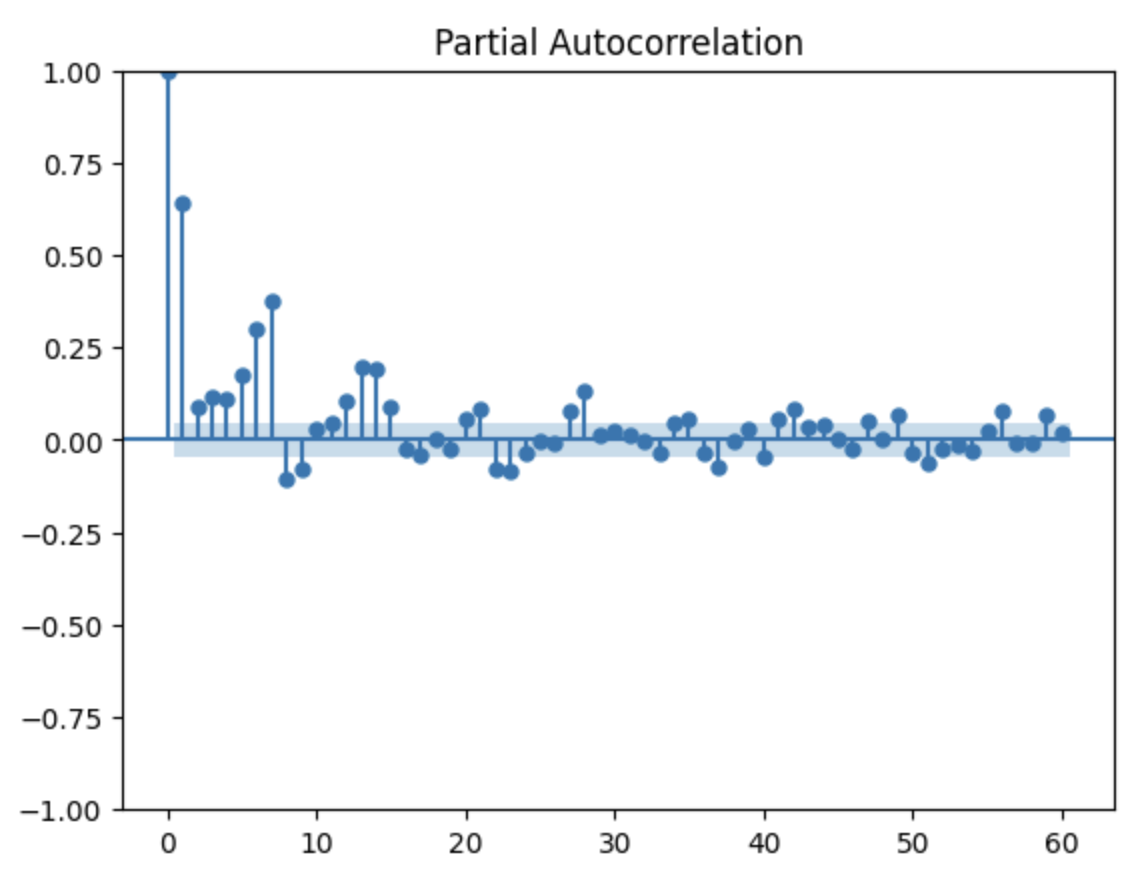

In [16]:
df_train['lag_1'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales_capped'].shift(1)
df_train['lag_7'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales_capped'].shift(7)
df_train['lag_14'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales_capped'].shift(14)
df_train['lag_21'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales_capped'].shift(21)
df_train['lag_28'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales_capped'].shift(28)

# bad predictions on a per store item basis
# adding lags 2-6 to see if it would make it better
df_train['lag_2'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales_capped'].shift(2)
df_train['lag_3'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales_capped'].shift(3)
df_train['lag_4'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales_capped'].shift(4)
df_train['lag_5'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales_capped'].shift(5)
df_train['lag_6'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales_capped'].shift(6)

## Rolling Statistics

The dataset shows a clear weekly seasonality, so a rolling window of 7 days seems most reasonable.

Capturing mean and standard deviation may help XGBoost learn weekly trend and variability respectively.

In [17]:
# drop the original computation, it was not shifted. also for consistency
df_train.drop(['unit_sales_7d_avg'], axis=1, inplace=True)

In [18]:
df_train['unit_sales_rolling_avg_7'] = (
    df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales']
      .shift(1)
      .rolling(window=7)
      .mean()
)

df_train['unit_sales_rolling_std_7'] = (
    df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales']
      .shift(1)
      .rolling(window=7)
      .std()
)

## Store- and Item-level data

From data prep, we already extracted item (family, class,  and perishable) as well as store ('city', 'type', 'state') data. State was captured only for ease of verification i.e. easier to know all rows were from Guayas. It should not be fed to the model.

In [19]:
df_train.drop(['state'], axis=1, inplace=True)

# Train Test Split

Use Jan to Feb 2014 as training data, and March 2014 as test

In [20]:
date_cutoff = '2014-03-01'
X_train = df_train[df_train['date'] < date_cutoff]
X_test = df_train[df_train['date'] >= date_cutoff]

y_train = X_train['unit_sales']
y_test = X_test['unit_sales']

X_train.drop(['unit_sales', 'unit_sales_capped', 'id', 'is_outlier'], axis=1, inplace=True)
X_test.drop(['unit_sales', 'unit_sales_capped', 'id', 'is_outlier'], axis=1, inplace=True)

/tmp/ipython-input-636343314.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['unit_sales', 'unit_sales_capped', 'id', 'is_outlier'], axis=1, inplace=True)
/tmp/ipython-input-636343314.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(['unit_sales', 'unit_sales_capped', 'id', 'is_outlier'], axis=1, inplace=True)


In [21]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(624923, 26) (624923,)
(342473, 26) (342473,)


In [22]:
X_train.columns

Index(['date', 'store_nbr', 'item_nbr', 'onpromotion', 'is_holiday', 'family',
       'class', 'perishable', 'city', 'type', 'year', 'month', 'day',
       'day_of_week', 'lag_1', 'lag_7', 'lag_14', 'lag_21', 'lag_28', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'unit_sales_rolling_avg_7',
       'unit_sales_rolling_std_7'],
      dtype='object')

In [23]:
X_train.head()

,date,store_nbr,item_nbr,onpromotion,is_holiday,family,class,perishable,city,type,...,lag_14,lag_21,lag_28,lag_2,lag_3,lag_4,lag_5,lag_6,unit_sales_rolling_avg_7,unit_sales_rolling_std_7
349,2014-01-01,24,96995,False,True,GROCERY I,1093,False,Guayaquil,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
350,2014-01-02,24,96995,False,False,GROCERY I,1093,False,Guayaquil,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
351,2014-01-03,24,96995,False,False,GROCERY I,1093,False,Guayaquil,D,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
352,2014-01-04,24,96995,False,False,GROCERY I,1093,False,Guayaquil,D,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
353,2014-01-05,24,96995,False,False,GROCERY I,1093,False,Guayaquil,D,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN


# Encoding Pipeline

In [24]:
def transform_cyclical_features(X):
  # transform month day into cyclical inputs so that the model learns
  # December is close to Janury, or Sunday is close to Monday
  X['month_sin'] = np.sin(2 * np.pi * X['month']/12)
  X['month_cos'] = np.cos(2 * np.pi * X['month']/12)
  X['dow_sin'] = np.sin(2 * np.pi * X['day_of_week']/7)
  X['dow_cos'] = np.cos(2 * np.pi * X['day_of_week']/7)
  return X

cyclical_transformer = FunctionTransformer(transform_cyclical_features, validate=False)

In [25]:
# Column groups
bool_cols = ['onpromotion', 'is_holiday', 'perishable']
num_cols = ['lag_1', 'lag_7', 'lag_14', 'lag_21', 'lag_28',
            'day', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
            'unit_sales_rolling_avg_7', 'unit_sales_rolling_std_7']

one_hot_cols = ['city', 'type', 'family', 'store_nbr']  # low-cardinality

target_cols = ['class', 'item_nbr']  # high-cardinality

cyclical_cols = ['month', 'day_of_week']

In [26]:
preprocessor = ColumnTransformer(transformers=[
    ('bool', OrdinalEncoder(dtype=int), bool_cols),
    ('num', 'passthrough', num_cols),  # tree-based model doesn't need scaling
    ('one_hot', OneHotEncoder(handle_unknown='ignore'), one_hot_cols),
    ('target', CatBoostEncoder(cols=target_cols, random_state=42), target_cols),
    ('cyclical', cyclical_transformer, cyclical_cols)
], remainder='drop')

In [27]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBRegressor(random_state=42, objective='reg:squarederror'))
])


# Grid Search and Cross-Validation Setup

In [28]:
tscv = TimeSeriesSplit(n_splits=5)

In [29]:

param_grid = {
    'xgb__n_estimators': [100, 500],
    'xgb__max_depth': [5, 10],
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__subsample': [0.7, 1.0],
    'xgb__colsample_bytree': [0.7, 1.0],
}
'''
param_grid = {
    'xgb__n_estimators': [100],
    'xgb__max_depth': [5],
    'xgb__learning_rate': [0.1],
    #'xgb__subsample': [0.7, 0.8, 1.0],
    #'xgb__colsample_bytree': [0.7, 0.8, 1.0],
}
'''


"\nparam_grid = {\n    'xgb__n_estimators': [100],\n    'xgb__max_depth': [5],               \n    'xgb__learning_rate': [0.1],          \n    #'xgb__subsample': [0.7, 0.8, 1.0],          \n    #'xgb__colsample_bytree': [0.7, 0.8, 1.0],   \n}\n"

In [30]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    # RMSE is typical for sales forecasting
    # negative beccause scikit learn tries to MAXIMIZE the scoring function
    # therefore multiplying by -1 will make big RMSE worse
    verbose=2,
    n_jobs=-1
)

# Model Fitting and Prediction

In [31]:
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

#Best parameters: {'xgb__colsample_bytree': 0.7, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 5, 'xgb__n_estimators': 100, 'xgb__subsample': 0.7}
#Best RMSE: 3.2509377126642898

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'xgb__colsample_bytree': 0.7, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 5, 'xgb__n_estimators': 100, 'xgb__subsample': 1.0}
Best RMSE: 3.2525069691622592


A model trained without the additional lags (2-6) and `day` with the following parameters has a VERY slightly better RMSE than the "expanded" configuration.

-----------------
No Lags 2-6 and Day
-----------------

Best parameters: {'xgb__colsample_bytree': 0.7,
  'xgb__learning_rate': 0.05,
  'xgb__max_depth': 5,
  'xgb__n_estimators': 100,
  'xgb__subsample': 0.7}

Best RMSE: 3.2509377126642898

---------------
With Lags 2-6 and Day
--------------

Best parameters: {'xgb__colsample_bytree': 0.7,
  'xgb__learning_rate': 0.05,
  'xgb__max_depth': 5,
  'xgb__n_estimators': 100,
  'xgb__subsample': 1.0}
Best RMSE: 3.2525069691622592

# Visualization

When taken as a whole, the predictions seem to reflect the peaks/seasonality for the most part. However, when trying to isolate store-item combinations, the predictions seem way off.

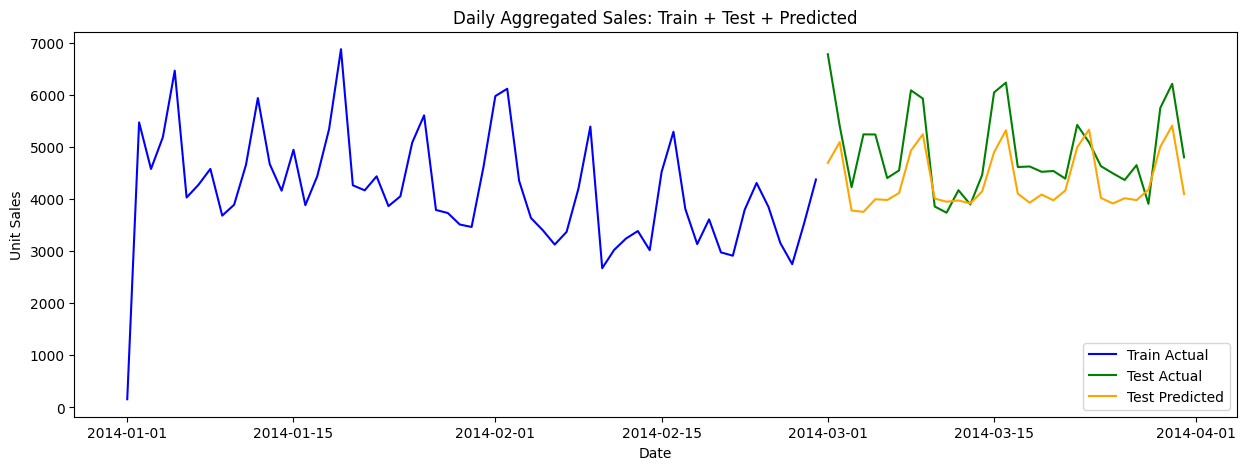

In [39]:
# --- Training data ---
train_df = pd.DataFrame({
    'date': X_train['date'].reset_index(drop=True),
    'actual': y_train.reset_index(drop=True)
})
train_daily = train_df.groupby('date').sum().reset_index()

# --- Test data ---
test_df = pd.DataFrame({
    'date': X_test['date'].reset_index(drop=True),
    'actual': y_test.reset_index(drop=True),
    'predicted': y_pred
})
test_daily = test_df.groupby('date').sum().reset_index()


plt.figure(figsize=(15,5))

# Training actuals
plt.plot(train_daily['date'], train_daily['actual'], label='Train Actual', color='blue')

# Test actuals
plt.plot(test_daily['date'], test_daily['actual'], label='Test Actual', color='green')

# Test predictions
plt.plot(test_daily['date'], test_daily['predicted'], label='Test Predicted', color='orange')

plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.title('Daily Aggregated Sales: Train + Test + Predicted')
plt.legend()
plt.show()


In [40]:
def plot_daily_aggregated_store_item(X_train, y_train, X_test, y_test, y_pred,
                                     store, item, rolling_window=None):
    """
    Plots daily aggregated sales for a specific store-item combination.
    Includes training actuals, test actuals, and test predictions.
    Optionally applies a rolling average.

    Parameters:
    - X_train, X_test: feature DataFrames (must include 'date', 'store_nbr', 'item_nbr')
    - y_train, y_test: Series of actual unit_sales
    - y_pred: numpy array or Series of predicted unit_sales for X_test
    - store, item: store number and item number to plot
    - rolling_window: int, optional rolling window size to smooth the curves
    """

    # --- Filter store-item ---
    train_subset = X_train[(X_train['store_nbr']==store) & (X_train['item_nbr']==item)].copy()
    train_subset['actual'] = y_train.loc[train_subset.index]

    test_subset = X_test.copy()
    test_subset['actual'] = y_test.values
    test_subset['predicted'] = y_pred
    test_subset = test_subset[(test_subset['store_nbr']==store)
                  & (test_subset['item_nbr']==item)].copy()
    test_subset = test_subset.reset_index(drop=True)
    #y_test_reset = y_test.reset_index(drop=True)
    #y_pred_reset = pd.Series(y_pred)
    #test_subset['actual'] = y_test_reset.loc[test_subset.index]
    #test_subset['predicted'] = y_pred_reset.loc[test_subset.index]
    #test_with_date['y_pred'] = y_pred # Adding the model's predictions (see above)
    #test_with_date['y_actual'] = y_test.values # Adding the actual sale values

    # --- Aggregate by day ---
    train_daily = train_subset.groupby('date')['actual'].sum().reset_index()
    test_daily = test_subset.groupby('date')[['actual','predicted']].sum().reset_index()

    # --- Optional rolling average ---
    if rolling_window is not None:
        train_daily['actual'] = train_daily['actual'].rolling(rolling_window).mean()
        test_daily['actual'] = test_daily['actual'].rolling(rolling_window).mean()
        test_daily['predicted'] = test_daily['predicted'].rolling(rolling_window).mean()

    # --- Plot ---
    plt.figure(figsize=(15,5))
    plt.plot(train_daily['date'], train_daily['actual'], label='Train Actual', color='blue')
    plt.plot(test_daily['date'], test_daily['actual'], label='Test Actual', color='green')
    plt.plot(test_daily['date'], test_daily['predicted'], label='Test Predicted', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.title(f'Daily Aggregated Sales: Store {store}, Item {item}')
    plt.legend()
    plt.show()

In [42]:
avg_sales = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].mean().reset_index()
top_5 = avg_sales.sort_values(by='unit_sales', ascending=False).head(5)
print(top_5)

      store_nbr  item_nbr  unit_sales
4789         28   1463900   30.000000
1118         24   1346637   20.500000
8601         35   1166474   19.666667
7261         34    807493   18.855556
1168         24   1463814   18.541667


In [43]:
sales_records = df_train.groupby(['store_nbr', 'item_nbr'])['id'].mean().reset_index()

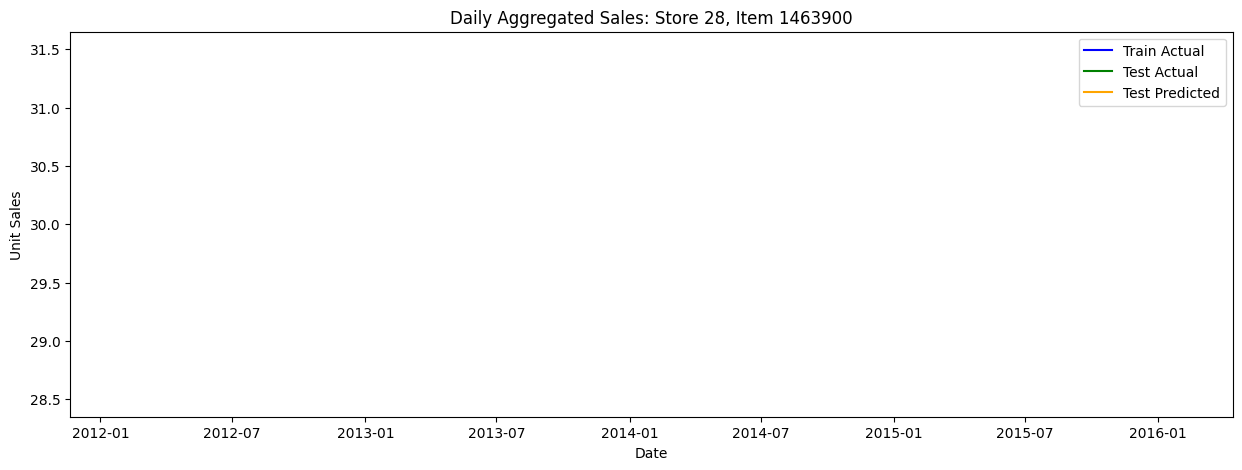

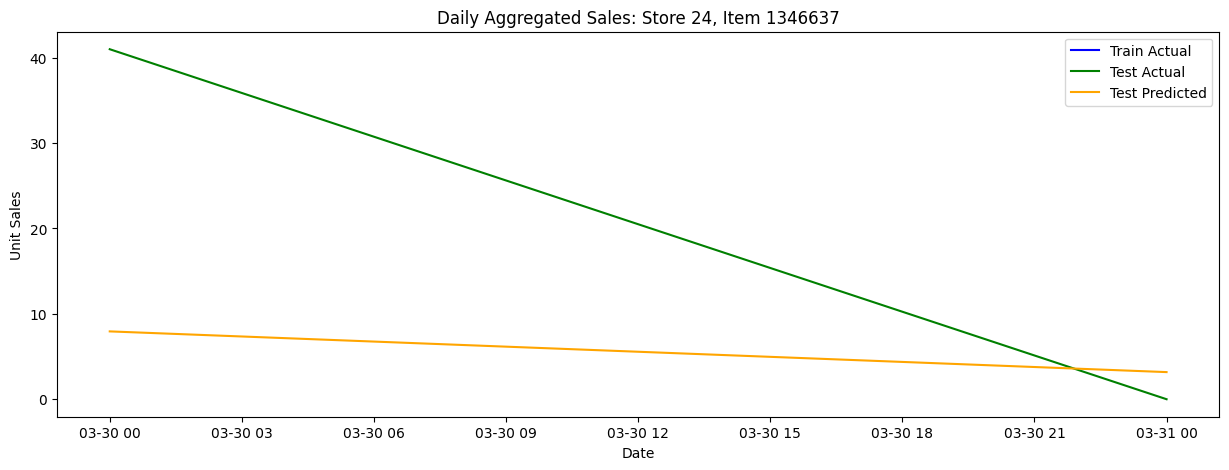

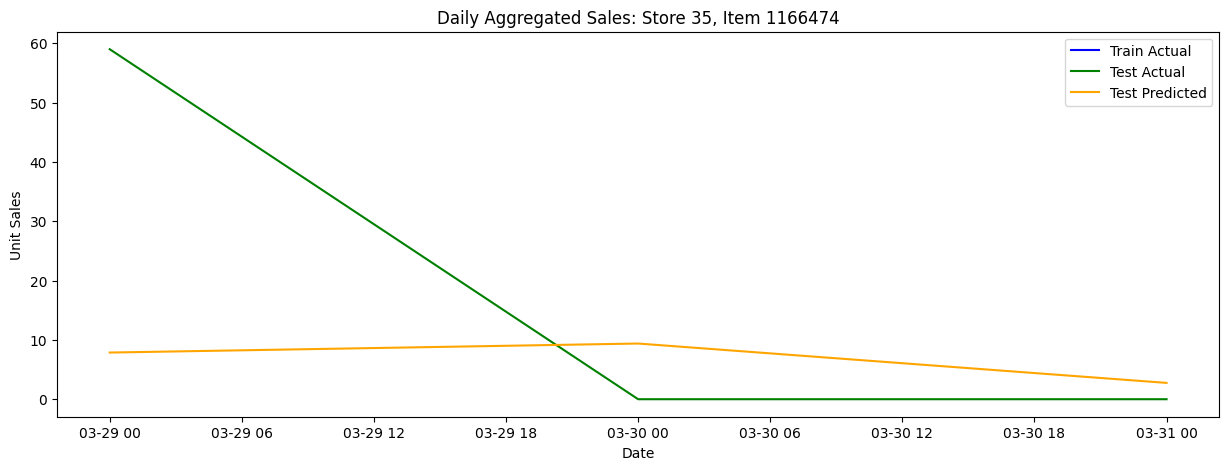

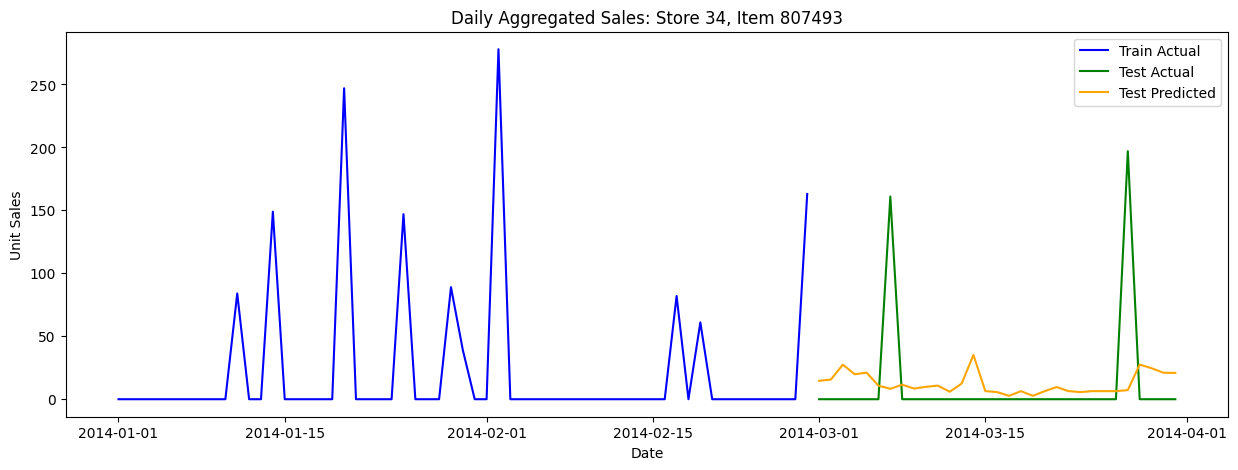

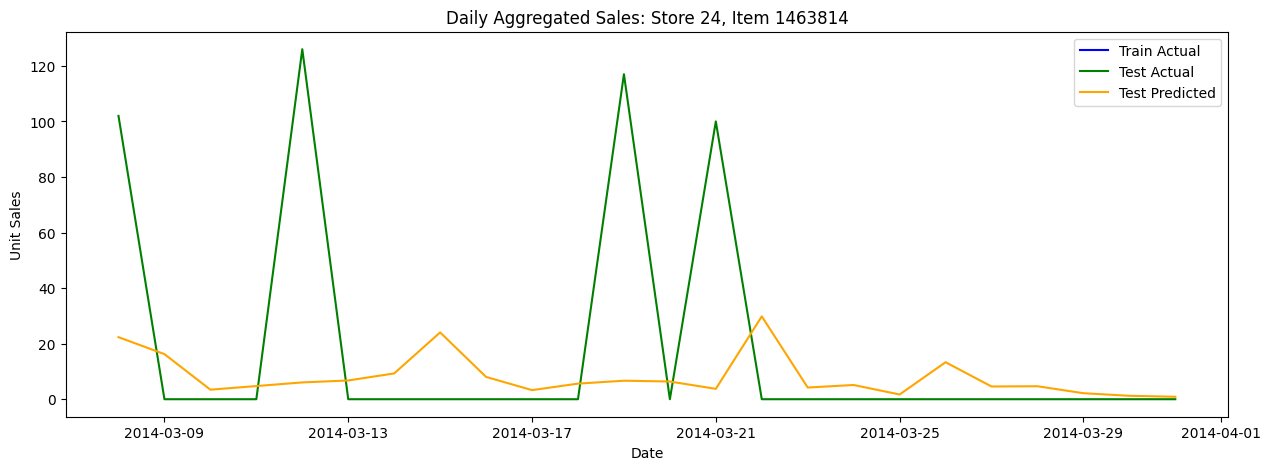

In [44]:
for row in top_5.itertuples():
    store = row.store_nbr
    item = row.item_nbr
    plot_daily_aggregated_store_item(X_train, y_train, X_test, y_test, y_pred,
                                 store, item)

In [45]:
df_experimental = df_train.copy()

In [46]:
df_experimental['positive_sales'] = df_experimental['unit_sales']>0

positive_counts = (
    df_experimental.groupby(['store_nbr', 'item_nbr'])
      ['positive_sales'].sum().reset_index()
)

In [47]:
top_5_most_sales_days = positive_counts.sort_values(by='positive_sales', ascending=False).head(5)
print(top_5_most_sales_days)

       store_nbr  item_nbr  positive_sales
135           24    226857              18
3780          28    210798              17
8479          35   1066900              17
10737         51   1047685              17
5884          32    224081              16


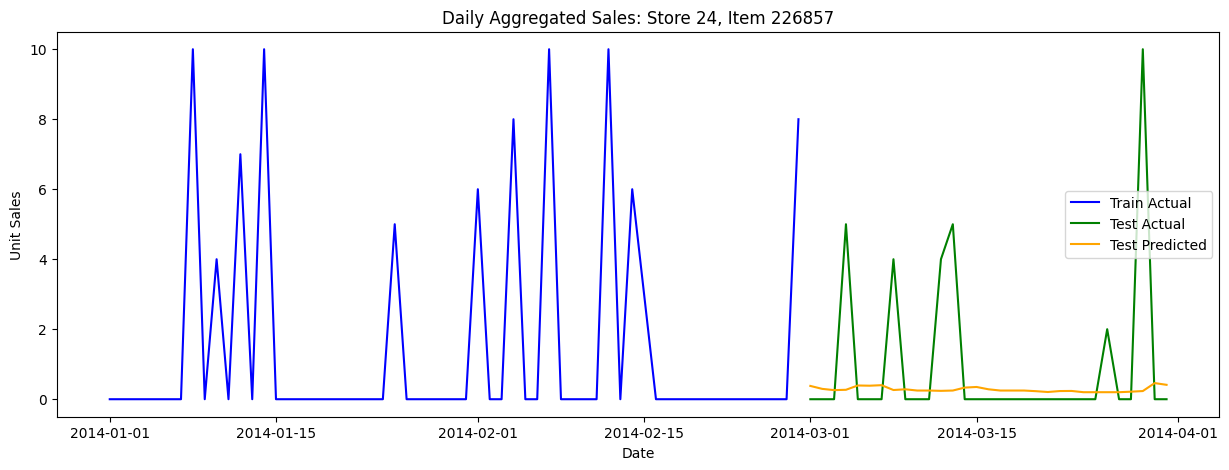

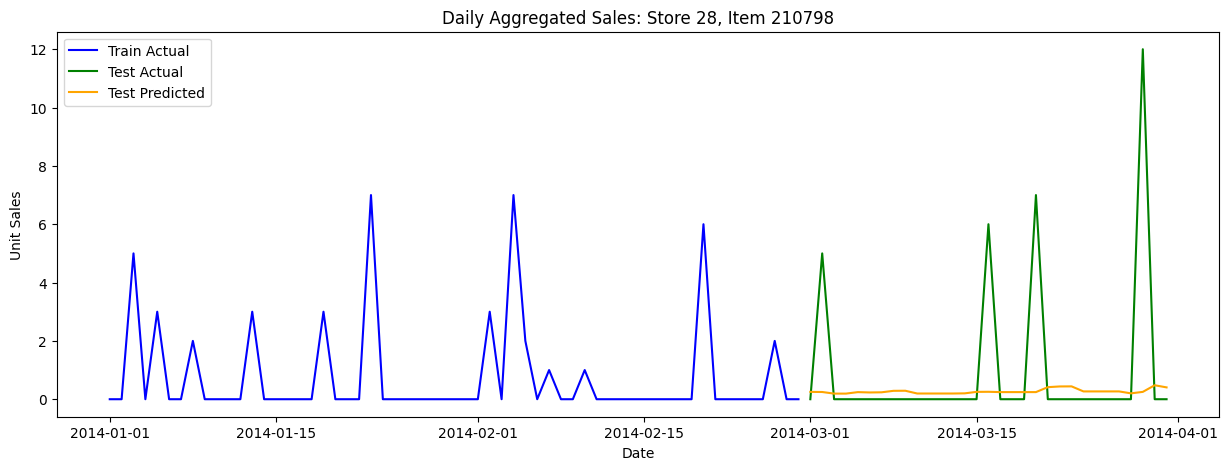

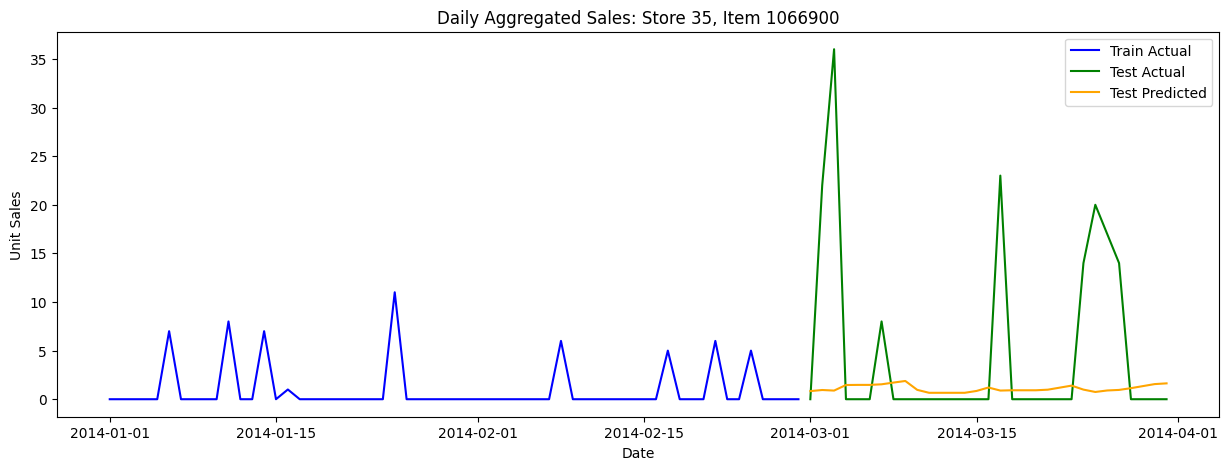

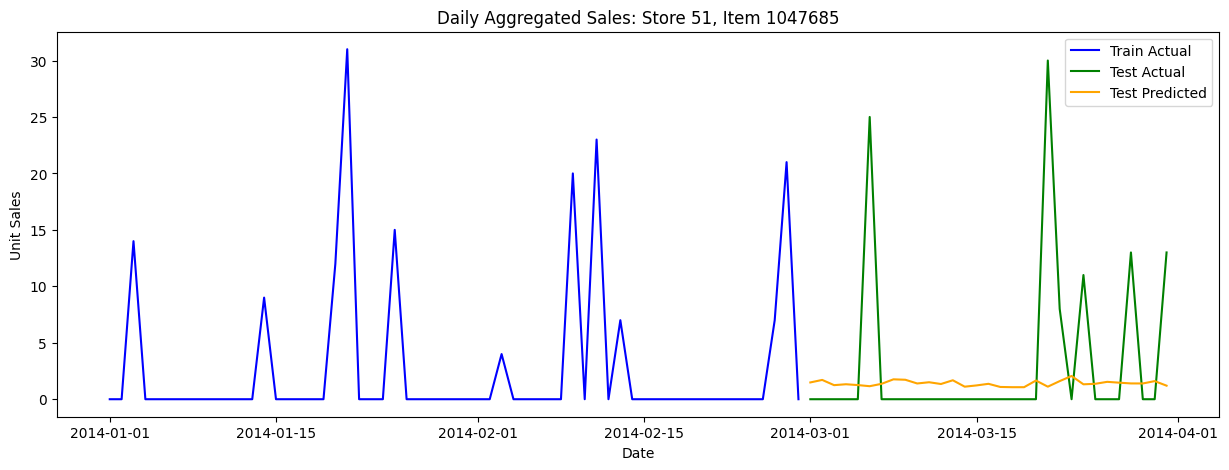

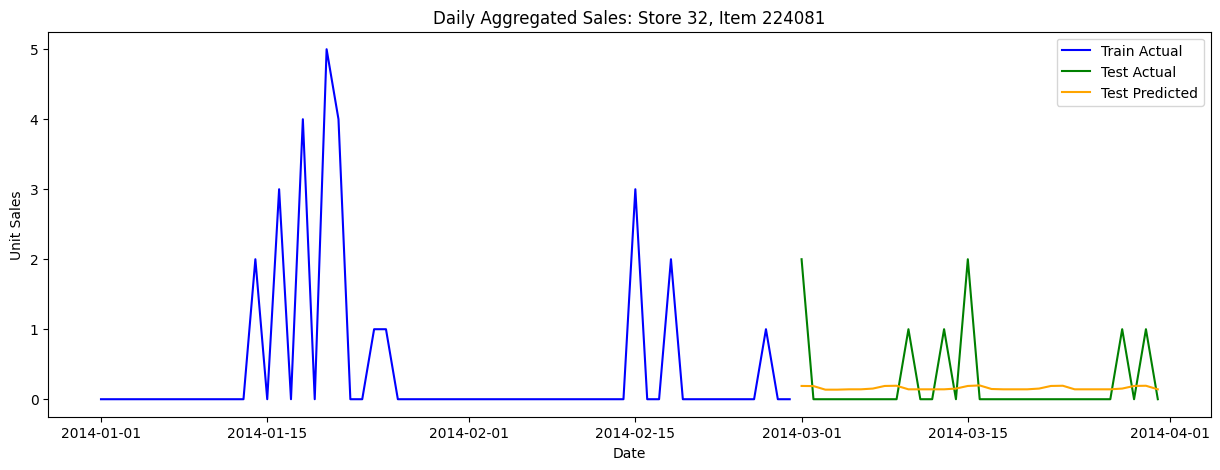

In [48]:
for row in top_5_most_sales_days.itertuples():
    store = row.store_nbr
    item = row.item_nbr
    plot_daily_aggregated_store_item(X_train, y_train, X_test, y_test, y_pred,
                                 store, item)